# Seminar 2. Linear regression and SGD

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
# import warnings
# warnings.filterwarnings("ignore")

random_seed = 218

matplotlib.rcParams.update({'font.size': 16})

In [2]:
n_features = 2
n_objects = 300
np.random.seed(random_seed)

# Let it be the *true* weights vector
w_true = np.random.normal(size=(n_features))

X = np.random.uniform(-5, 5, (n_objects, n_features))

# For different scales of features. In case of 3 features the code is equal to the commented line below
# X *= np.arange([1, 3, 5])[None, :]
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :] 

# Here comes the *true* target vector
Y = X.dot(w_true) + np.random.normal(0, 1, n_objects)

*Recap:*
In case of linear model
$$
\hat{Y} = X\mathbf{w}
$$
and __MSE__ loss function
$$
Q(Y, X, \mathbf{w}) = MSE(Y, X\mathbf{w}) =  \|Y - X\mathbf{w}\|^2_2 = \sum_i (y_i - \mathbf{x}^T_i \mathbf{w})^2
$$
analytical solution takes simple form:

$$
\mathbf{w}^* = (X^T X)^{-1}X^T Y.
$$

Let's check how it works:

In [3]:
w_star = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)

In [4]:
w_star

array([-0.91708811, -0.43298381])

In [5]:
w_true

array([-0.90954235, -0.42935367])

As we can see, the analytical solution is quite close to the original one. 

Now let's generate the dataset with correlated features:

In [6]:
n_features = 3
n_objects = 300
eps = 1e-3

# Let it be the *true* weights vector
w_true = np.random.normal(size=(n_features, ))

X = np.random.uniform(-5, 5, (n_objects, n_features))

# Now we duplicate the second feature with some small noise, so featues 2 and 3 are collinear
X[:, -1] = X[:, -2] + np.random.uniform(-eps, eps, X[:, -2].shape)

# Here comes the *true* target vector
Y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))

In [7]:
w_star = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)
w_star

array([   0.13761495,  101.80659537, -100.31577565])

In [8]:
w_true

array([0.17854841, 0.25226725, 1.27145114])

As we can see, the second and third coefficents are opposite. This makes our model highly *unstable*.

How could one actually fix it? Here comes the __regularization__.

Let's use the L2 norm of weigths vector as a regularization term to constrain the desired solution.

$$
Q_{\text{reg}}(Y, X, \mathbf{w}) = MSE(Y, X\mathbf{w}) + \lambda\|\mathbf{w}\|_2^2=  \|Y - X\mathbf{w}\|^2_2 + \lambda\|\mathbf{w}\|^2_2= \sum_i (y_i - \mathbf{x}^T_i \mathbf{w})^2 + \sum_p w^2_p
$$

Analytical solution is available in this case as well:

$$
\mathbf{w}^*_{\text{reg}} = (X^T X + \lambda I_p)^{-1}X^T Y,
$$
where $I_p$ is diagonal matrix consisting of 1s (with size p).

__Be careful with the regularization term if you have included the column of 1s into X matrix! We do not want regularize the bias (free) term in our linear model.__

In [9]:
reg = 1e-0
w_star_reg = np.linalg.inv(X.T.dot(X) + reg*np.eye(n_features)).dot(X.T).dot(Y)
w_star_reg

array([0.14012638, 0.751607  , 0.74047681])

In [10]:
w_true

array([0.17854841, 0.25226725, 1.27145114])

### Gradient descent

The analytical solution described above includes invertion of the matrix $X^T X$ (or $X^T X + \lambda I$), which is quite expensive in terms of computation resourses. The complexity of matrix inversion can be estimated as $O(p^3 + p^2 N)$. This leads us to the iterative optimization methods, which are more efficient and are de-facto the main approach to optimization in Machine Learning.

Gradient descent is one of the most popular optimization methods. Worth to mention the fact that the minimization (maximization) target (e.g loss function value) should be differentiable w.r.t model parameters. Using the gradient descent, the weights vector $\mathbf{w}^{(t+1)}$ on step $t+1$ can be expressed in the following form:
$$
\mathbf{w}^{(t+1)} = \mathbf{w}^{(t)} - \eta_t \nabla Q(\mathbf{w}^{(t)}),
$$
where $\eta_t$ stays for the gradient step (usually referred as _learning rate_).

The gradient in case of MSE loss function takes the following form:

$$
\nabla Q(\mathbf{w}) = -2X^TY + 2X^TX\mathbf{w} = 2X^T(X\mathbf{w} - Y).
$$

In this case the complexity is only $O(pN)$. To make it even more effective (and using the hypothesis of homogeneous data in the dataset) one could use _stochastic gradient descent_, which computes the gradient only over some random subset of data K points, so the final complexity decreases to $O(pK)$, where $K << N$.

### Visuailizing the gradient descent trajectory
This part is deeply based on [Evgeny Sokolov](https://github.com/esokolov) open materials.

Let's take a close look on the optimization path in simple two-dimentional space (where features are in different scales). We will use MSE loss function.

The plots below show $\mathbf{w}^{(t)}$ values on every step $t$. The red dot in the center stays for $\mathbf{w}_{\text{true}}$.

In [11]:
random_seed = 43
n_features = 2
n_objects = 300
num_steps = 43
np.random.seed(random_seed)

# Let it be the *true* weights vector
w_true = np.random.normal(size=(n_features, ))

X = np.random.uniform(-5, 5, (n_objects, n_features))

# For different scales of features. In case of 3 features the code is equal to the commented line below
# X *= np.arange([1, 3, 5])[None, :]
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :] 

# Here comes the *true* target vector
Y = X.dot(w_true) + np.random.normal(0, 1, n_objects)

In [12]:
np.random.seed(random_seed)
w_0 = np.random.uniform(-2, 2, n_features)-0.5
w = w_0.copy()
w_list = [w.copy()]
step_size = 1e-2

for i in range(num_steps):
    w -= step_size * 2. * np.dot(X.T, (X.dot(w) - Y)) / Y.size # YOUR CODE HERE
    w_list.append(w.copy())
w_list = np.array(w_list)

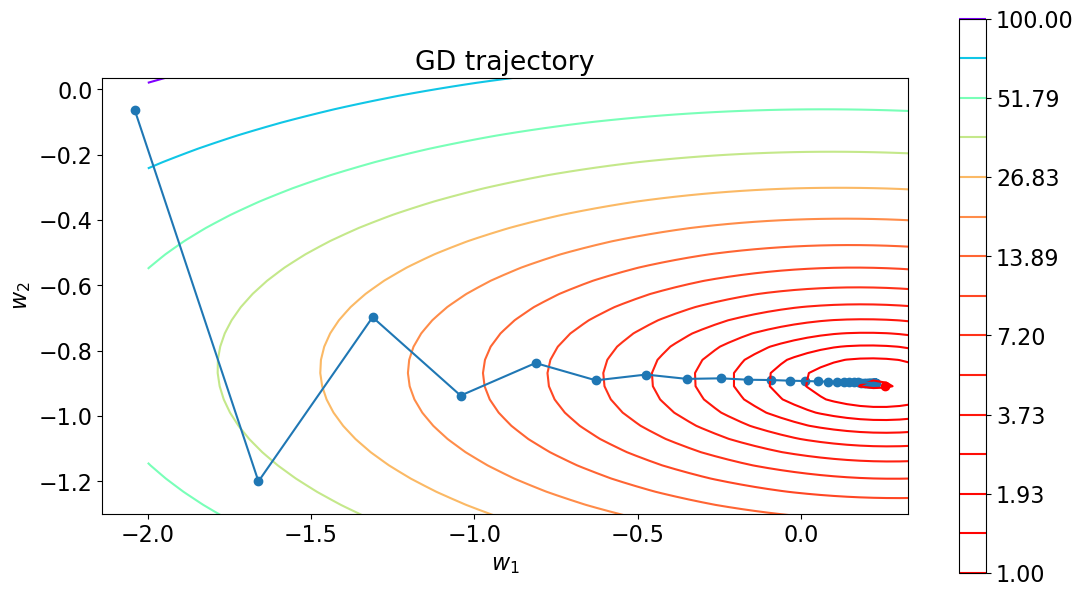

In [13]:
# compute level set
A, B = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))

levels = np.empty_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        w_tmp = np.array([A[i, j], B[i, j]])
        levels[i, j] = np.mean(np.power(np.dot(X, w_tmp) - Y, 2))

plt.figure(figsize=(13, 9))
plt.title('GD trajectory')
plt.xlabel('$w_1$')
plt.ylabel('$w_2$')
plt.xlim(w_list[:, 0].min() - 0.1, w_list[:, 0].max() + 0.1)
plt.ylim(w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1)
plt.gca().set_aspect('equal')

# visualize the level set
CS = plt.contour(A, B, levels, levels=np.logspace(0, 2, num=15), cmap=plt.cm.rainbow_r)
CB = plt.colorbar(CS, shrink=0.8, extend='both')

# visualize trajectory
plt.scatter(w_true[0], w_true[1], c='r')
plt.scatter(w_list[:, 0], w_list[:, 1])
plt.plot(w_list[:, 0], w_list[:, 1])

plt.show()

The gradient vector is orthogonal to the equipotential surface . That's the reason why the optimization path is not so smooth. Let's visualize the gradient directions to make it more clear.

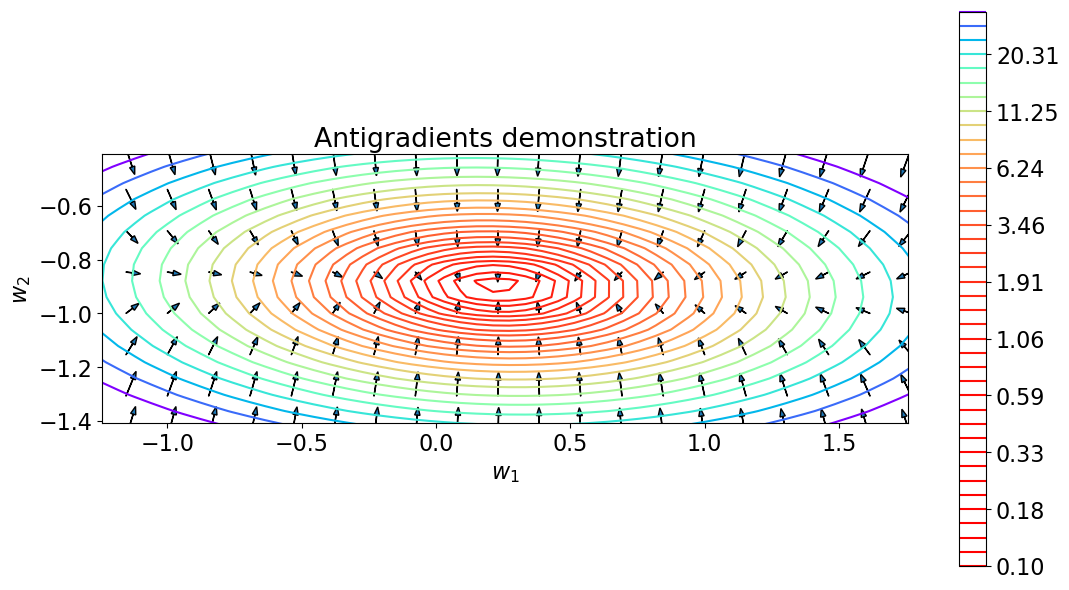

In [14]:
# compute level set
A, B = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
A_mini, B_mini = np.meshgrid(np.linspace(-3, 3, 40), np.linspace(-3, 3, 40))

levels = np.empty_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        w_tmp = np.array([A[i, j], B[i, j]])
        levels[i, j] = np.mean(np.power(np.dot(X, w_tmp) - Y, 2))
        
# visualize the level set
plt.figure(figsize=(13, 9))
CS = plt.contour(A, B, levels, levels=np.logspace(-1, 1.5, num=40), cmap=plt.cm.rainbow_r)
CB = plt.colorbar(CS, shrink=0.8, extend='both')
        
# visualize the gradients
gradients = np.empty_like(A_mini)
for i in range(A_mini.shape[0]):
    for j in range(A_mini.shape[1]):
        w_tmp = np.array([A_mini[i, j], B_mini[i, j]])
        antigrad = - 2 * 1e-3 * np.dot(X.T, np.dot(X, w_tmp) - Y) / Y.shape[0]
        plt.arrow(A_mini[i, j], B_mini[i, j], antigrad[0], antigrad[1], head_width=0.02)

plt.title('Antigradients demonstration')
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')
plt.xlim((w_true[0] - 1.5, w_true[0] + 1.5))
plt.ylim((w_true[1] - .5, w_true[1] + .5))
plt.gca().set_aspect('equal')
plt.show()

Now let's take a look at the _stochastic gradient descent_. Let the number of elements the loss function computed on each state (`batch_size`) be equal to $10$.

In [15]:
np.random.seed(random_seed)
batch_size = 10
w = w_0.copy()
w_history_list = [w.copy()]
lr = 1e-2

for i in range(num_steps):
    sample_indices = np.random.randint(n_objects, size=batch_size)# YOUR CODE HERE
    w -= 2 * lr * np.dot(X[sample_indices].T, np.dot(X[sample_indices], w) - Y[sample_indices]) / batch_size
# YOUR CODE HERE
    w_history_list.append(w.copy())
w_history_list = np.array(w_history_list)

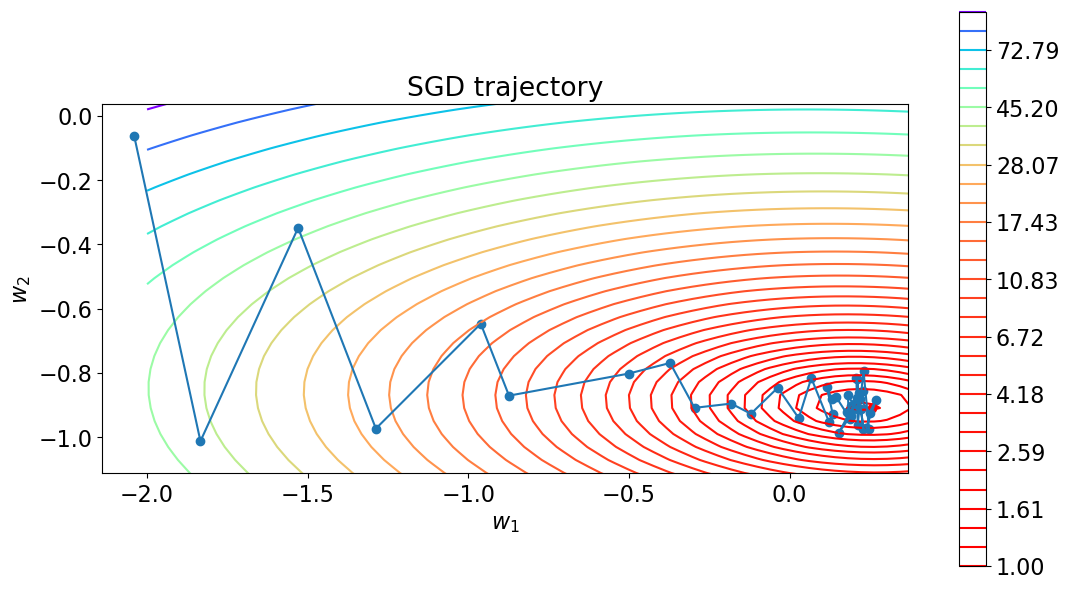

In [16]:
# compute level set
A, B = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))

levels = np.empty_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        w_tmp = np.array([A[i, j], B[i, j]])
        levels[i, j] = np.mean(np.power(np.dot(X, w_tmp) - Y, 2))


plt.figure(figsize=(13, 9))
plt.title('SGD trajectory')
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')
plt.xlim((w_history_list[:, 0].min() - 0.1, w_history_list[:, 0].max() + 0.1))
plt.ylim((w_history_list[:, 1].min() - 0.1, w_history_list[:, 1].max() + 0.1))
plt.gca().set_aspect('equal')

# visualize the level set
CS = plt.contour(A, B, levels, levels=np.logspace(0, 2, num=30), cmap=plt.cm.rainbow_r)
CB = plt.colorbar(CS, shrink=0.8, extend='both')

# visualize trajectory
plt.scatter(w_true[0], w_true[1], c='r')
plt.scatter(w_history_list[:, 0], w_history_list[:, 1])
plt.plot(w_history_list[:, 0], w_history_list[:, 1])

plt.show()

As you can see from the plot, SGD "wanders" around the optima. It is controlled by the SGD step size $\eta_k$ and the convergence is not guaranteed in general case. For SGD method convergence given the sequence of steps $\{\eta_k\}$ it is necessary that [Robbins-Monroe Conditions](https://projecteuclid.org/download/pdf_1/euclid.aoms/1177729586) are satisfied:
$$
\sum_{k = 1}^\infty \eta_k = \infty, \qquad \sum_{k = 1}^\infty \eta_k^2 < \infty.
$$
More intuitively, those conditions may be explained as follows:
1. A sequence of steps $\{\eta_k\}$ should diverge, so optimization method is capable or reaching any point in the given parameter space,
2. At the same time it should diverge "not so fast"

Let's analyze SGD trajectories, which are generated by a sequence of steps, satisfying the Robbins-Monroe Conditions:

In [17]:
np.random.seed(random_seed)
w = w_0.copy()
w_list = [w.copy()]
lr_0 = 0.45

for i in range(num_steps):
    lr = lr_0 / ((i+1) ** 0.5) # What should the power be? )
    sample_indices = np.random.randint(n_objects, size=batch_size) # YOUR CODE HERE
    w -= 2 * lr * np.dot(X[sample_indices].T, np.dot(X[sample_indices], w) - Y[sample_indices]) / Y.shape[0] # YOUR CODE HERE
    w_list.append(w.copy())
w_list = np.array(w_list)

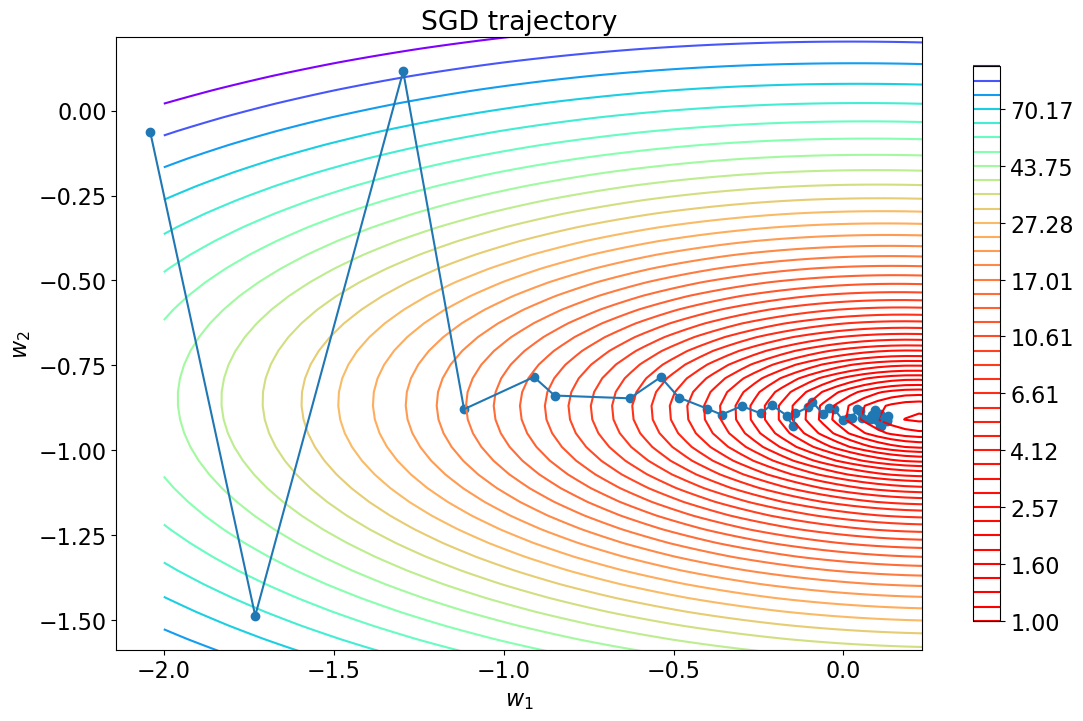

In [18]:
# compute level set
A, B = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))

levels = np.empty_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        w_tmp = np.array([A[i, j], B[i, j]])
        levels[i, j] = np.mean(np.power(np.dot(X, w_tmp) - Y, 2))

plt.figure(figsize=(13, 9))
plt.title('SGD trajectory')
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')
plt.xlim((w_list[:, 0].min() - 0.1, w_list[:, 0].max() + 0.1))
plt.ylim((w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1))
plt.gca().set_aspect('equal')

# visualize the level set
CS = plt.contour(A, B, levels, levels=np.logspace(0, 2, num=40), cmap=plt.cm.rainbow_r)
CB = plt.colorbar(CS, shrink=0.8, extend='both')

# visualize trajectory
plt.scatter(w_true[0], w_true[1], c='r')
plt.scatter(w_list[:, 0], w_list[:, 1])
plt.plot(w_list[:, 0], w_list[:, 1])

plt.show()

### Comparing the convergence speed
Finally, it is important to compare the convergence speed for full and stochastic GD. Let's generate a random dataset and plot the loss function value w.r.t. iteration number

In [19]:
# data generation
n_features = 50
n_objects = 1000
num_steps = 500
batch_size = 10

w_true = np.random.uniform(-2, 2, n_features)

X = np.random.uniform(-10, 10, (n_objects, n_features))
Y = X.dot(w_true) + np.random.normal(0, 5, n_objects)

In [20]:
lr_sgd = 1e-3
lr_gd = 1e-3
w_sgd = np.random.uniform(-4, 4, n_features)
w_gd = w_sgd.copy()
residuals_sgd = [np.mean(np.power(np.dot(X, w_sgd) - Y, 2))]
residuals_gd = [np.mean(np.power(np.dot(X, w_gd) - Y, 2))]

for i in range(num_steps):
    lr = lr_sgd / ((i+1) ** 0.51)
    sample = np.random.randint(n_objects, size=batch_size)
    w_sgd -= 2 * lr * np.dot(X[sample].T, np.dot(X[sample], w_sgd) - Y[sample]) / batch_size
    residuals_sgd.append(np.mean(np.power(np.dot(X, w_sgd) - Y, 2)))
    
    w_gd -= 2 * lr_gd * np.dot(X.T, np.dot(X, w_gd) - Y) / Y.shape[0]
    residuals_gd.append(np.mean(np.power(np.dot(X, w_gd) - Y, 2)))

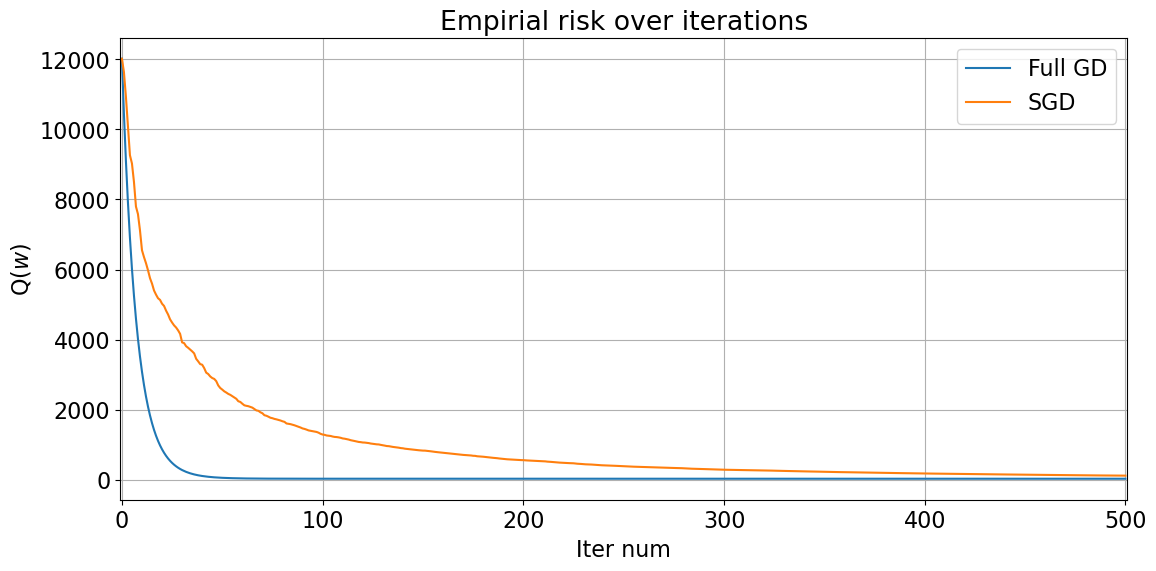

In [21]:
plt.figure(figsize=(13, 6))
plt.plot(range(num_steps+1), residuals_gd, label='Full GD')
plt.plot(range(num_steps+1), residuals_sgd, label='SGD')
plt.title('Empirial risk over iterations')
plt.xlim((-1, num_steps+1))
plt.legend()
plt.xlabel('Iter num')
plt.ylabel(r'Q($w$)')
plt.grid()
plt.show()

As demonstrated, GD reaches optima within several iterations, while SGD may appear less stable and requires more time to converge. Usually larger models demonstrate larger fluctuations for loss function values during the convergence process of stochastic gradient-based methods. In practice, SGD step size may be adjusted to achieve better convergence speed and there are several methods which implement adaptive gradient descent step size: AdaGrad, Adam, RMSProp etc.

## Own Linear Regression

In [22]:
from sklearn.base import BaseEstimator, RegressorMixin
# also ClassifierMixin and TransformerMixin exist

In [23]:
class LinearRergessionSGD(BaseEstimator, RegressorMixin):
    '''LinearRergession with L2 regularization and SGD optimizer
    '''
    def __init__(
        self, C: float=1.0,
        batch_size: int=25,
        lr: float=1e-2,
        num_steps: int=200,
    ) -> None:
        self.C = C
        self.batch_size = batch_size
        self.lr = lr
        self.num_steps = num_steps

    def fit(self, X, Y):
        w = np.random.randn(X.shape[1])[:, None]
        n_objects = len(X)

        # this is just copied from above
        for i in range(self.num_steps):
            sample_indices = np.random.randint(n_objects, size=self.batch_size)
            w -= 2 * self.lr * np.dot(X[sample_indices].T, np.dot(X[sample_indices], w) - Y[sample_indices]) / self.batch_size

        self.w = w
        return self

    def predict(self, X):
        return X@self.w

Let's generate dataset with differently scaled features

In [24]:
n_features = 700
n_objects = 100000
num_steps = 150

w_true = np.random.uniform(-2, 2, (n_features, 1))

X = np.random.uniform(-100, 100, (n_objects, n_features)) * np.arange(n_features)
Y = X.dot(w_true) + np.random.normal(0, 10, (n_objects, 1))

and split it to train and test

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
x_train, x_test, y_train, y_test = train_test_split(X, Y)

Now let's test our solution

In [27]:
own_lr = LinearRergessionSGD().fit(x_train, y_train)
print(f'R2: {own_lr.score(x_test, y_test)}')

ValueError: Input contains NaN.

OOOOOOOOOPS!!!

Something went wrong. What could it be?

During our SGD we've encountered too big values to store in float.

That leads us to feature normalization.
Lest's scale features: just subtract mean from each feature and divide by sample variation

In [28]:
from sklearn.preprocessing import StandardScaler

In [29]:
scaler = StandardScaler()
scaler.fit(x_train)
x_scaled = scaler.transform(x_train)

In [30]:
own_lr = LinearRergessionSGD().fit(x_scaled, y_train)

But for test we need to scale test features

In [31]:
x_test_scaled = scaler.transform(x_test)

In [32]:
print(f'R2: {own_lr.score(x_test_scaled, y_test)}')

R2: 0.9965227046314091


Wow! we didn't implement no `score` method. But `sklearn`'s base class provide us it aleready implemented.

You note that scaling data before prediction is not a big pleasure. So we could get rid of this bulkiness with pipelines

In [33]:
from sklearn.pipeline import make_pipeline

In [34]:
pipe = make_pipeline(
    StandardScaler(),
    LinearRergessionSGD(),
)

In [35]:
pipe.fit(x_train, y_train)
print(f'R2: {pipe.score(x_test, y_test)}')

R2: 0.9964964339374621


As if we don't have any complex assembly behind pipeline interface!

And no data leak guaranteed as a gift!